In [1]:
import pandas as pd
import numpy as np

import requests
import openpyxl as xl
import time
import json

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings(action='ignore') # 경고메세지 숨기기

In [2]:
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
df = pd.read_excel("real_fin_zero.xlsx")
df

,gd_nm,goo_nm,dong_ID,dong_nm,sum_pop,one_hh,cc_value,count_zero,sum_bus,sum_station,sum_rank,y,x
0,강남구 개포1동,강남구,11680660,개포1동,6670,468,0,0,1375563,0,24,37.481925,127.057439
1,강남구 개포2동,강남구,11680670,개포2동,22297,900,0,0,2063259,0,21,37.489766,127.069056
2,강남구 개포4동,강남구,11680690,개포4동,22765,1938,10,0,2191248,0,15,37.478833,127.051599
3,강남구 논현1동,강남구,11680521,논현1동,23734,6054,30,0,6614782,12558668,18,37.511498,127.028552
4,강남구 논현2동,강남구,11680531,논현2동,21997,3926,30,0,4271209,11846451,19,37.517353,127.037164
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,송파구 잠실7동,송파구,11710720,잠실7동,9903,251,0,0,1491348,2999128,35,37.508661,127.077090
65,송파구 잠실본동,송파구,11710650,잠실본동,29093,5462,30,0,3519634,1537940,33,37.506167,127.084325
66,송파구 장지동,송파구,11710646,장지동,30370,2288,30,0,3540476,0,32,37.477368,127.131914
67,송파구 풍납1동,송파구,11710510,풍납1동,14585,1556,0,0,1185664,0,34,37.538055,127.122215


In [4]:
df["one_ratio"] = df["one_hh"]/df["sum_pop"]
df["sum_trans"] = df["sum_bus"] + df["sum_station"]

In [5]:
df2=df[['goo_nm', 'dong_nm', 'sum_rank','one_ratio', 'cc_value', 'count_zero', 'sum_trans']]

In [6]:
df2.to_excel("ecorank_ahp_df.xlsx")

# 쌍대비교 행렬 생성
입지 평가 지표로 선정된 지표의 가중치를 산정하기 
위해 AHP 분석을 시행

In [8]:
mt = pd.read_excel("mid_ahp.xlsx") 
mt2 = mt[mt["count_zero"]!=1] # count_zero 배제하고 생각
mt2 = mt2.drop(columns={"count_zero"})
mt2 = mt2.reset_index()
mt2 = mt2.drop(columns={"index"})

In [9]:
mt2

,goo_nm,dong_nm,sum_rank,one_ratio,cc_value,sum_trans
0,강남구,개포1동,24,0.070165,0,1375563
1,강남구,개포2동,21,0.040364,0,2063259
2,강남구,개포4동,15,0.085131,10,2191248
3,강남구,논현1동,18,0.255077,30,19173450
4,강남구,논현2동,19,0.178479,30,16117660
...,...,...,...,...,...,...
60,송파구,잠실6동,27,0.027698,20,29746442
61,송파구,잠실7동,35,0.025346,0,4490476
62,송파구,잠실본동,33,0.187743,30,5057574
63,송파구,장지동,32,0.075338,30,3540476


In [10]:
mt2.describe()

,sum_rank,one_ratio,cc_value,sum_trans
count,65.000000,65.000000,65.000000,6.500000e+01
mean,24.723077,0.103590,21.769231,6.598060e+06
std,5.287094,0.064215,11.948809,6.772997e+06
min,15.000000,0.011957,0.000000,6.674170e+05
25%,21.000000,0.056450,10.000000,2.494415e+06
50%,24.000000,0.092495,30.000000,4.490476e+06
75%,29.000000,0.141341,30.000000,6.839578e+06
max,37.000000,0.294444,30.000000,3.468040e+07


비교 우위 : sum_rank(환경) > one_ratio(1인가구) > cc_value(상권) > sum_trans (유동인구)

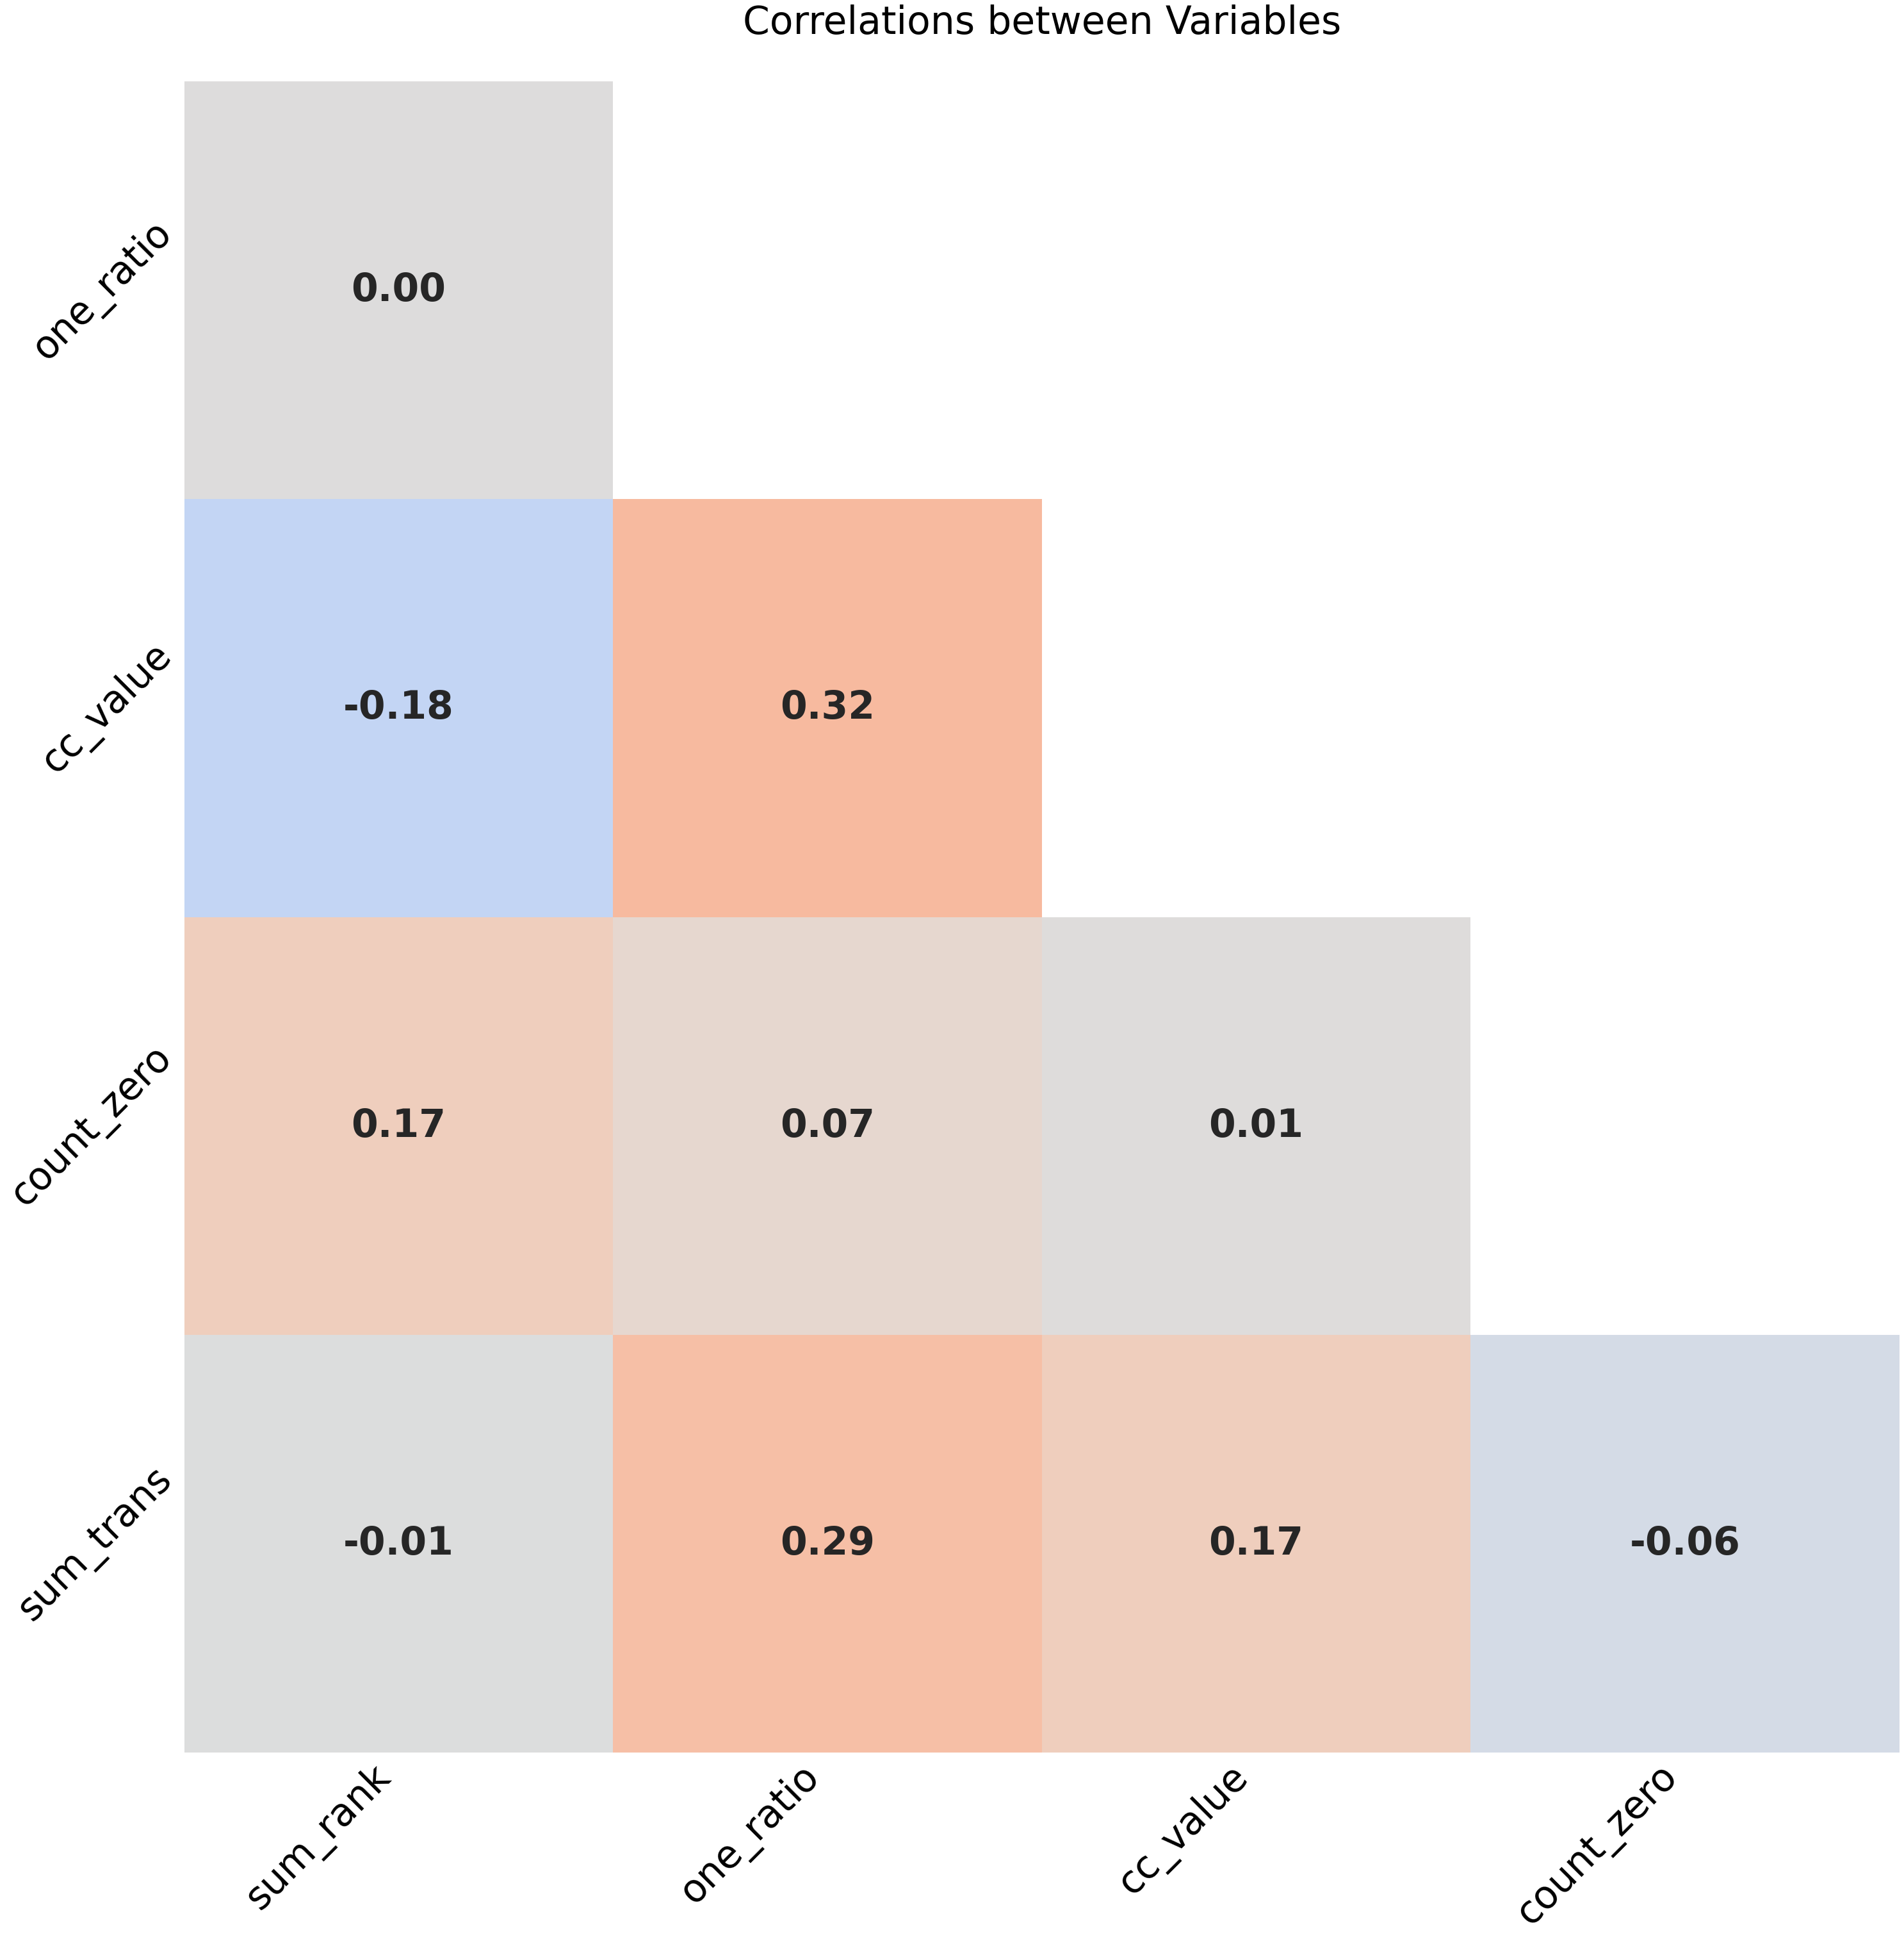

In [12]:
corr=mt.drop(columns=['goo_nm', 'dong_nm']).corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':60,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=60)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=60)
plt.title('Correlations between Variables\n', fontsize=60)
fig.show()

상관관계가 높은 것은 변수 선택에서 제외하는 것이 일반적이나 상관계수가 0.5미만이기 때문에 모두 선택하여 ahp 를 실행하는 것이 적합하다고 본다.

# 엑셀 표(수식)을 이용해서 생성 
#### (AHP_Calculator_zero.xlsx 참고)

# 1) 기하 평균 (실패)
https://shinho0902.tistory.com/18

In [17]:
import pandas as pd
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt

In [46]:
df2 = pd.read_excel("ahp_comparison_matrix.xlsx")
df2 = df2.rename(columns={"Unnamed: 0":"index"})
df2.set_index("index",inplace=True) 

In [47]:
ahp_df = df2.copy()
ahp_df

,환경,1인가구,상권,유동인구
index,,,,
환경,1.000000,2.300000,1.083333,1.133333
1인가구,0.434783,1.000000,0.833333,0.866667
상권,0.923077,1.200000,1.000000,1.083333
유동인구,0.882353,1.153846,0.923077,1.000000


In [48]:
# 데이터프레임의 컬럼수 파악
colums_cnt = len(ahp_df.columns)
colums_cnt

4

In [49]:
# 각 컬럼의 기하평균을 계산하여 리스트에 저장
geo_mean_list = []
for i in ahp_df:
    geo_mean_list.append(gmean(ahp_df[i])) # 기하 평균
    
geo_mean_list

[0.7714151506529505, 1.335870290918819, 0.9554426966600732, 1.0156472554670526]

In [50]:
# 기하평균 출력
print('기하평균 (Geometric mean)\n')
for i,j in zip(ahp_df, geo_mean_list):
    #print('{} : {}'.format(i, j))
    print('{} : {}'.format(i, round(j,3)))  # 소수점 3 자리수

기하평균 (Geometric mean)

환경 : 0.771
1인가구 : 1.336
상권 : 0.955
유동인구 : 1.016


In [51]:
# 데이터프레임에 기하평균값 추가
ahp_df = ahp_df.append(pd.Series(geo_mean_list, index=ahp_df.columns),ignore_index=True)
ahp_df

,환경,1인가구,상권,유동인구
0,1.000000,2.300000,1.083333,1.133333
1,0.434783,1.000000,0.833333,0.866667
2,0.923077,1.200000,1.000000,1.083333
3,0.882353,1.153846,0.923077,1.000000
4,0.771415,1.335870,0.955443,1.015647


In [52]:
# 가중치 계산을 위하여 기하평균의 합을 구함 -> 4번째 행 합계
geo_mean_sum = sum(geo_mean_list)
geo_mean_sum

4.078375393698895

In [53]:
# 각 컬럼의 가중치를 계산하여 리스트에 저장
weights_list = []
for i in range(colums_cnt):
    weights_list.append(geo_mean_list[i]/geo_mean_sum)

In [54]:
# 기하평균 출력
print('가중치 (Weights)\n')
for i,j in zip(ahp_df, weights_list): # weights_list : 가중치 리스트
    print('{} : {}'.format(i, j))
    #print('{} : {}'.format(i, round(j,3)))  # 소수점 3 자리수

가중치 (Weights)

환경 : 0.18914765713935744
1인가구 : 0.3275496152175554
상권 : 0.2342704151599766
유동인구 : 0.24903231248311064


In [55]:
# 가중치 합 확인
su_ = sum(list(weights_list))
print(su_)

1.0


In [56]:
# 데이터프레임에 가중치 값 추가
ahp_df2 = ahp_df.append(pd.Series(weights_list, index=ahp_df.columns),ignore_index=True)
ahp_df2

,환경,1인가구,상권,유동인구
0,1.000000,2.300000,1.083333,1.133333
1,0.434783,1.000000,0.833333,0.866667
2,0.923077,1.200000,1.000000,1.083333
3,0.882353,1.153846,0.923077,1.000000
4,0.771415,1.335870,0.955443,1.015647
5,0.189148,0.327550,0.234270,0.249032


In [57]:
# 인덱스명 변경
ahp_df_result = ahp_df2.rename({0:'환경', 1:'1인가구', 2:'상권', 3:'유동인구', 4:'기하평균', 5:'가중치'}, axis=0)
ahp_df_result

,환경,1인가구,상권,유동인구
환경,1.000000,2.300000,1.083333,1.133333
1인가구,0.434783,1.000000,0.833333,0.866667
상권,0.923077,1.200000,1.000000,1.083333
유동인구,0.882353,1.153846,0.923077,1.000000
기하평균,0.771415,1.335870,0.955443,1.015647
가중치,0.189148,0.327550,0.234270,0.249032


In [60]:
# 가중치 결과만 가지고 있는 데이터프레임 생성
ahp_df_result_weights = ahp_df_result.loc[['가중치'],['환경', '1인가구', '상권', '유동인구']]
ahp_df_result_weights.T

,가중치
환경,0.189148
1인가구,0.327550
상권,0.234270
유동인구,0.249032


In [61]:
x = list(ahp_df_result_weights.columns)
y = weights_list

In [62]:
# 그래프 한글 출력을 위함
plt.rcParams['font.family'] = 'Malgun Gothic' 

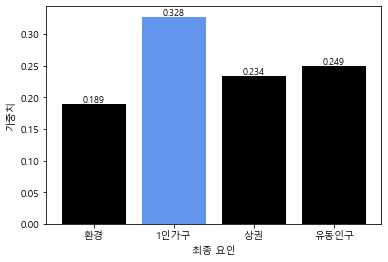

In [66]:
plt.bar(x, y, color=['black','cornflowerblue','black','black'])
plt.xlabel('최종 요인')
plt.ylabel('가중치')


for i, v in enumerate(x):
    plt.text(v, y[i],round(y[i],3),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom', # verticalalignment (top, center, bottom)
            )    
    
# plt.savefig('AHP_막대그래프',dpi=300) # 막대그래프 결과를 저장
plt.show()

# 2) 표준정규화 (실패)

In [135]:
ahp_df = df2.copy()
ahp_df

,환경,1인가구,상권,유동인구
index,,,,
환경,1.000000,2.300000,1.083333,1.133333
1인가구,0.434783,1.000000,0.833333,0.866667
상권,0.923077,1.200000,1.000000,1.083333
유동인구,0.882353,1.153846,0.923077,1.000000


In [103]:
len(ahp_df.index)

4

In [123]:
# 각 컬럼의 기하평균/ 을 계산하여 리스트에 저장
geo_mean_list = []
geo_std_list = []

for i in range(len(ahp_df.index)):
    geo_mean_list.append(ahp_df.T.iloc[i].sum()/len(ahp_df.T.iloc[i])) # 평균
    geo_std_list.append(((ahp_df.T.iloc[i]-geo_mean_list[i])**2/len(ahp_df.T.iloc[i])).sum()) # 분산
    geo_std_list[i] = geo_std_list[i]**(1/2) # 표준편차
    
print(geo_mean_list)
print(geo_std_list)

[0.8100532541221123, 1.4134616606805213, 0.9599358017751698, 1.020833165]
[0.22074279139380615, 0.5171717931146719, 0.09249166709471439, 0.1009502034147117]


In [126]:
for i in range(len(ahp_df.index)):
    ahp_df.T.iloc[i]  =  (ahp_df.T.iloc[i]-geo_mean_list[i]) / geo_std_list[i]

In [127]:
ahp_df

,환경,1인가구,상권,유동인구
index,,,,
환경,0.860489,1.714205,1.334144,1.114409
1인가구,-1.700036,-0.799467,-1.368802,-1.527154
상권,0.512017,-0.412747,0.433165,0.619115
유동인구,0.327530,-0.501991,-0.398507,-0.206371


In [134]:
round(ahp_df.T.loc["환경"].sum(),6)

-0.0

# 3) 합계 norm 확인 (성공)

In [137]:
ahp_df = df2.copy()
ahp_df

,환경,1인가구,상권,유동인구
index,,,,
환경,1.000000,2.300000,1.083333,1.133333
1인가구,0.434783,1.000000,0.833333,0.866667
상권,0.923077,1.200000,1.000000,1.083333
유동인구,0.882353,1.153846,0.923077,1.000000


In [138]:
# 각 컬럼의 합계
geo_sum_list = []

for i in range(len(ahp_df.index)):
    geo_sum_list.append(ahp_df.T.iloc[i].sum()) # 평균
    
geo_sum_list

[3.240213016488449, 5.653846642722085, 3.839743207100679, 4.08333266]

In [139]:
# 데이터프레임에 합계값 추가
ahp_df = ahp_df.append(pd.Series(geo_sum_list, index=ahp_df.columns),ignore_index=True)
ahp_df

,환경,1인가구,상권,유동인구
0,1.000000,2.300000,1.083333,1.133333
1,0.434783,1.000000,0.833333,0.866667
2,0.923077,1.200000,1.000000,1.083333
3,0.882353,1.153846,0.923077,1.000000
4,3.240213,5.653847,3.839743,4.083333


In [205]:
# norm 완료
ahp_norm = ahp_df.iloc[:4,:] / ahp_df.iloc[4]

norm_sum_list = []

for i in range(4):
    norm_sum_list.append(ahp_norm.T.iloc[i].sum())
    
# 데이터프레임에 가중치 값 추가
ahp_norm = ahp_norm.append(pd.Series(norm_sum_list, index = ahp_norm.columns),ignore_index=True)
ahp_norm

,환경,1인가구,상권,유동인구
0,0.308622,0.406803,0.282137,0.277551
1,0.134183,0.176871,0.217028,0.212245
2,0.284882,0.212245,0.260434,0.265306
3,0.272313,0.204082,0.240401,0.244898
4,1.000000,1.000000,1.000000,1.000000


In [218]:
# 모든 비교 행렬에 대해 norm 후 가중치 계산
norm_weight_list = []

for i in range(4):
    norm_weight_list.append(ahp_norm.iloc[i].sum()/4)

norm_weight_list.append(sum(norm_weight_list))

In [219]:
norm_weight_list

[0.3187780478263212,
 0.18508183024103794,
 0.25571669364147176,
 0.24042342829116914,
 1.0]

In [220]:
ahp_norm["가중치"] = norm_weight_list

In [221]:
ahp_norm

,환경,1인가구,상권,유동인구,가중치
0,0.308622,0.406803,0.282137,0.277551,0.318778
1,0.134183,0.176871,0.217028,0.212245,0.185082
2,0.284882,0.212245,0.260434,0.265306,0.255717
3,0.272313,0.204082,0.240401,0.244898,0.240423
4,1.000000,1.000000,1.000000,1.000000,1.000000


### 가중치

In [228]:
x = list(ahp_df.columns)
y = norm_weight_list[:4]

In [229]:
# 그래프 한글 출력을 위함
plt.rcParams['font.family'] = 'Malgun Gothic' 

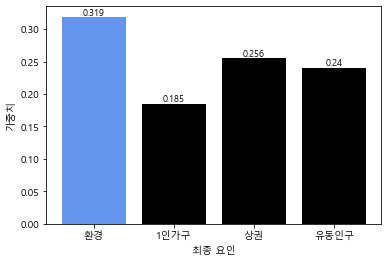

In [232]:
plt.bar(x, y, color=['cornflowerblue','black','black','black'])
plt.xlabel('최종 요인')
plt.ylabel('가중치')


for i, v in enumerate(x):
    plt.text(v, y[i],round(y[i],3),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom', # verticalalignment (top, center, bottom)
            )    
    
plt.savefig('AHP_막대그래프',dpi=300) # 막대그래프 결과를 저장
plt.show()

# 일관성 비율 계산

In [298]:
ahp_lambda = ahp_df.iloc[:4,:]
ahp_lambda["가중치"] = ahp_norm["가중치"].iloc[:4]
# 1번 2번 곱합 - > 3번 생성
ahp_lambda["행렬곱"] =  np.dot(ahp_lambda.iloc[:,:4], ahp_lambda["가중치"]) 
ahp_lambda

,환경,1인가구,상권,유동인구,가중치,행렬곱
0,1.000000,2.300000,1.083333,1.133333,0.318778,1.293972
1,0.434783,1.000000,0.833333,0.866667,0.185082,0.745145
2,0.923077,1.200000,1.000000,1.083333,0.255717,1.032530
3,0.882353,1.153846,0.923077,1.000000,0.240423,0.971300


In [272]:
#ahp_lambda["행렬곱"] = [np.dot(ahp_lambda.iloc[:4,0],ahp_lambda["가중치"]),
#np.dot(ahp_lambda.iloc[:4,1],ahp_lambda["가중치"]),
#np.dot(ahp_lambda.iloc[:4,2],ahp_lambda["가중치"]),
#np.dot(ahp_lambda.iloc[:4,3],ahp_lambda["가중치"])]

In [301]:
# 3번을 2번으로 나눔
ahp_lambda["lambda"]= ahp_lambda["행렬곱"]/ahp_lambda["가중치"] 
ahp_lambda

,환경,1인가구,상권,유동인구,가중치,행렬곱,lambda
0,1.000000,2.300000,1.083333,1.133333,0.318778,1.293972,4.059164
1,0.434783,1.000000,0.833333,0.866667,0.185082,0.745145,4.026031
2,0.923077,1.200000,1.000000,1.083333,0.255717,1.032530,4.037790
3,0.882353,1.153846,0.923077,1.000000,0.240423,0.971300,4.039958


In [302]:
lambda_max = ahp_lambda["lambda"].sum() / len(ahp_lambda["lambda"])
lambda_max

4.040735630780919

 일반적으로 CR이 0.10 이하(n ≥ 5인 경우), 0.09 이하(n = 4인 경우), 0.05 이하(n = 3인 경우)이면 허용되는 것으로 간주

In [303]:
# ※ CI(Consistency Index)는 0.1 이하의 값은 일관성을 신뢰할 수 있음을 의미
# 응답에 있어 논리적 모순을 검증하는 지표가 C.I

n=4
CI = (lambda_max-n)/(n-1) # 일관성 지수
CI 

0.0135785435936396

In [304]:
# ※ RI(Random Consistency Index)는 평균 무작위 수준(Saaty, 1982) 기준에 따라 0.9으로 적용
# http://blog.skby.net/ahp-analytic-hierarchy-process/
RI = 0.9
CR = CI/RI # 일관성 비율
CR

0.015087270659599555